<a href="https://colab.research.google.com/github/gfgullo/ImageCaptioning/blob/master/image_captioning_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pic2Speech - A Neural Image Captioning Model
In this Notebook we will create a Neural Image Captioning Model mostly based on the paper "Show and Tell: A Neural Image Caption Generator" by Vinyals et al. (1). Our model will be able to generate a description for a given picture. After building the model we will deploy it in production with Azure ML Model Serving and we will use it inside a mobile app called **Pic2Speech**, whit purpose of help visually impaired understanding the world, describing vocally the content of picture taking with the camera of their smartphone.

## The Dataset
The Neural Network that will power our model will be trained on the full MS COCO 2019 Dataset. This dataset contains 82783 pictures with 5 human's generated captions each. Let's download the full dataset from its orignal repository and extract the zip with unzip.

In [5]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
  
!unzip annotations_trainval2014.zip
!unzip train2014.zip

--2019-09-01 08:40:45--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.137.164
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.137.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  36.2MB/s    in 7.3s    

2019-09-01 08:40:53 (33.2 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

--2019-09-01 08:40:54--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.111.75
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.111.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  36.6MB/

Now inside the directory *annotations* we can find a JSON file called *captions_train2014.json*, it contains all the captions in the format:
<br><br>
*{<br>
&nbsp;"annotations": <br>
&nbsp; { <br>
&emsp;"image_id":IMAGE_ID, <br>
&emsp;"caption": CAPTION} <br>
&nbsp;},<br>
&nbsp;...<br>
}*

Where IMAGE_ID is the id of the image to which the caption refers and CAPTION is the caption. Inside the folder train2014 we can find the actual images in jpg format, image are named with this standard
<br><br>
*COCO_train2014_**IMAGE_ID**.jpg*
<br><br>
in this case IMAGE_ID is always a 13 characters long string where the last character are the actual IMAGE_ID and all the others are 0. For example an IMAGE_ID of 317672 in captions_train2014.json will refer to the image *COCO_train2014_0000000317672.jpg*.


## Dependencies
We will build the model using **Keras** on top of **Tensorflow 1.14**, we will also use some functions of scikit-learn for data preprocessing and model selection. We will use **BLEU (2)** a scoring method mostly used in Machine Translation evaluation that will fit good also for our purpose, we will use it with **NLTK**.

In [0]:
import numpy as np

import json
import string
import pickle
import os
from time import time
from random import randint

from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

from keras.layers import Input, Dropout, Embedding, LSTM, Dense
from keras.layers.merge import add

from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu

from IPython.display import display

## Preprocess the Text
Let's begin preprocessing all captions, we can limit the number of images we want use to train our model putting the number inside *img_count*, we could do this if we don't have enough computing capability to train the model on the entire dataset. If you want to train the model on the entire dataset just put None.<br>
We will process the caption applying the following operation:
* Convert the entire string in lower case
* Remove all the punctuation from the string
* Add string delimiter using *startseq* and *endseq*, we have to do this because our model need to know when a caption end and when the next begin.

After this we will save the caption in a dictionary where the key is the image id.

In [14]:
CAPTIONS_FILE = "annotations/captions_train2014.json"

imgs_count = 1000

img_captions = {}

with open(CAPTIONS_FILE) as captions_file:
  
  captions_json = json.loads(captions_file.read())
  
  for caption in captions_json["annotations"]:
        
    caption_text = caption["caption"]
    caption_text = caption_text.lower() # convert the text in lowercase
    caption_text = caption_text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    caption_text = "startseq "+caption_text+" endseq" # add start and end of sequence delimiter
    
    img_id = caption["image_id"]

    if(img_id in img_captions):
      img_captions[img_id].append(caption_text)
    else:
      img_captions[img_id] = [caption_text]
      if(imgs_count!=None):
        imgs_count-=1
        if(imgs_count <= 0):
          break

len(img_captions)

1000

Now use the dictionary to create two separated list for images id and for captions, in this way all the captions that refers to an image will be next to eachother in the list. This is important because when we split the sets for train and test we will be sure that images that will be used for test are not also inside the train set, so the evaluation on the test set will be much mor reliable. Of course to train the model we have to shuffle the train set, but we will do this later.

In [15]:
captions_text, captions_img = [], []

for img_id in img_captions:
  for caption in img_captions[img_id]:
    captions_img.append(img_id)
    captions_text.append(caption)

print(captions_text[:20])
print(captions_img[:20])

['startseq a very clean and well decorated empty bathroom endseq', 'startseq a blue and white bathroom with butterfly themed wall tiles endseq', 'startseq a bathroom with a border of butterflies and blue paint on the walls above it endseq', 'startseq an angled view of a beautifully decorated bathroom endseq', 'startseq a clock that blends in with the wall hangs in a bathroom  endseq', 'startseq a panoramic view of a kitchen and all of its appliances endseq', 'startseq a panoramic photo of a kitchen and dining room endseq', 'startseq a wide angle view of the kitchen work area endseq', 'startseq multiple photos of a brown and white kitchen  endseq', 'startseq a graffitied stop sign across the street from a red car  endseq', 'startseq a vandalized stop sign and a red beetle on the road endseq', 'startseq a red stop sign with a bush bumper sticker under the word stop endseq', 'startseq a stop sign that has been vandalized is pictured in front of a parked car endseq', 'startseq a street sig

## Load the Image Encoder

Now let's move to the images,we will enconde the images in a 2048 vectors' space using the **InceptionV3 model (3)**, we can load the model pretrained on the **ImageNet (4)** with Keras. Since we want to encode the images and not recognize their contents we will remove the output layer from the model. 

In [0]:
HEIGHT = 299
WIDTH = 299
OUTPUT_DIM = 2048

encode_model = InceptionV3(weights='imagenet') # load the model
encode_model = Model(encode_model.input, encode_model.layers[-2].output) # remove the output layer

## Preprocess the Images
To preprocess the image we will load each image in a loop, resize it to match the input size of 299x299 for the Inception V3 model and feed it to the model, the we will save the ouput inside a dictionary, where the key is again the image id. Since this process could require a lot of time we will dump the dictionary on a file using **pickle**, so the next time we can load this file instead of preprocessing again every image.

In [0]:
ENCODED_IMGS_FILE = "features.pkl"

if(os.path.exists(ENCODED_IMGS_FILE)):
  
  with open(ENCODED_IMGS_FILE,"rb") as handle:
    encoded_imgs = pickle.load(handle)

else:

  IMG_PATH = "train2014/"

  imgs_id = set(captions_img)
  encoded_imgs = {}

  for i, img_id in enumerate(imgs_id):

    img_file = 'COCO_train2014_' + '%012d.jpg' % img_id
    img = load_img(IMG_PATH+img_file)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)  
    arr = img_to_array(img)

    x = preprocess_input(arr)
    x = np.expand_dims(x, axis=0)

    features = encode_model.predict(x)
    features = np.reshape(features, OUTPUT_DIM)

    encoded_imgs[img_id]=features

    with open(ENCODED_IMGS_FILE,"wb") as handle:
      pickle.dump(encoded_imgs ,handle)      

## Create the Train, Test and Validation Set

In [18]:
captions_text_train, captions_text_test, captions_img_train, captions_img_test = train_test_split(captions_text, captions_img, test_size=0.05, random_state=0)

print("Sample in Train Set: %d " % len(captions_text_train))
print("Sample in Test Set: %d " % len(captions_text_test))

Sample in Train Set: 4229 
Sample in Test Set: 223 


## Create the Tokenizer
It's time for tokenization ! This process consits in splitting the text in its constituent parts, called tokens. Many words our text corpus could be very rare and such words could bring just noise to our model. So let's take only the words which appear at least 5 times in the entire text corpus. Let's define a functions to get the vocabulary and another one to count the number of words which appear at least 5 times

In [19]:
def get_vocab(captions):
  
  vocab = {}
  
  for caption in captions:
    words = caption.split()
    
    for word in words:
      
      if(word in vocab):
        vocab[word]+=1
      else:
        vocab[word]=1
   
  return vocab


def count_top_words(captions, min_count=5):
  
  vocab = get_vocab(captions)
  top_words = 0
    
  for word in vocab:
    
    if(vocab[word]>min_count):
      top_words+=1
      
  return top_words
  
  
VOCAB_SIZE = count_top_words(captions_text)
print(VOCAB_SIZE)

698


Now we can use the Keras' Tokenizer class, to perform tokenization on both train and test set, passing the vocabulary size in the *num_words* param.

In [0]:
VOCAB_SIZE = count_top_words(captions_text)

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(captions_text)

sequences_train = tokenizer.texts_to_sequences(captions_text_train)
sequences_test = tokenizer.texts_to_sequences(captions_text_test)

How long is the longest caption in the train set ? To build our model we need this information, let's get it.

In [22]:
MAX_LEN = max(len(tokens) for tokens in sequences_train)
print(MAX_LEN)

28


## Build a Generator

Great ! We are almost done with data preprocessing, last steps are:
* Create sequences of data, where for each word in each caption we will create a sequence with the word as the target and all the preceding words in the captions as features.
* We pad each features sequence to make every sequence the same length
* We creates dummy variables for the target encoding it with One hot Encoding.

But there is an huge problem in the last step, if we use the full dataset the resulting array will get really big, how big ?
* We have 393407 captions in our train set, let's say that a caption is long 10 words in average plus the 2 delimiters startseq and endseq, so we will we have 11 sequences for caption, we also have 8103 in our vocabulary, this means that the array with the target encoded with One Hot Encoding will weight
<br><br>
* *393407 x 11 x 8103 x 4 = 35065546131 bytes ≈ 140 Gigabyte*
<br>

I multiplied by 4 because Keras uses float for One Hot Encoding, that's really much for my tiny RAM. 
<br><br>
What we can do ? We can use a generator and create our samples on the fly during training, this will make the training time much longer but will save our RAM.<br>
<br>
Now it's also time to shuffle our set, we will do this at every epoch.

In [0]:
def create_sequence(seq, caption_img, max_length, vocab_size):
  
  x1, x2, y = [], [], []

    
  for i in range(len(seq)-1):
    x1.append(encoded_imgs[caption_img])
    x2.append(pad_sequences([seq[:i+1]], maxlen=max_length)[0]) # pad the sequence
    y.append(to_categorical([seq[i+1]], num_classes=vocab_size)[0]) # perform one hot encoding  
      
  return x1, x2, y


def data_generator(sequences, captions_img, max_length, vocab_size, batch_size=None):
 
  tot_samples = len(sequences)
  
  if(batch_size==None):
    batch_size=tot_samples
  
  n_batches = int(tot_samples/batch_size)
  
  while 1:
    
    batch_start = 0
    sequences, captions_img = shuffle(sequences, captions_img) # time to shuffle 
    
    
    for _ in range(n_batches):
            
      X1, X2, Y = [], [], [] 
      
      batch_end = batch_start+batch_size
            
      if(batch_end>tot_samples):
        batch_end = tot_samples
        
      sequences_batch = sequences[batch_start:batch_end] 
      captions_img_batch = captions_img[batch_start:batch_end]     
                
      for seq, caption_img in zip(sequences_batch, captions_img_batch):
        
        x1, x2, y = create_sequence(seq, caption_img, max_length, vocab_size)
        
        if(len(X1)==0):
          X1, X2, Y = x1, x2, y
        else:
          X1, X2, Y = X1+x1, X2+x2, Y+y

      batch_start+=batch_size
        
      yield [[np.array(X1), np.array(X2)],np.array(Y)]      

## Create the Embedding

We can start building our Model ! The first layer of our Neural Network will perform Words Embedding (5), that will encode words in a N-dimensional vector space where similar relate words are near to each other. We will use a pretrained Word Embedding Model, the GloVe Model (6). We can download the model from its directory and unzip it.

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-08-31 10:48:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-31 10:48:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-31 10:48:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We got 4 file with 4 different number of embeddings, 50, 100, 200 and 300, for our model we will use the 100d embedding. For every row we have the word and then the embedding values separated by spaces. Let's define a function to load the embedding inside a dictionary, where the key is the corresponding word.

In [0]:
def load_embedding(filename):
  
  with open(filename) as file:
    lines = file.readlines()

  embedding = dict()
  
  for line in lines:
    parts = line.split()
    embedding[parts[0]] = np.asarray(parts[1:])
    
  return embedding

raw_embedding = load_embedding('glove.6B.100d.txt')

Now we can use the embedding dictionary to build an embedding weights matrix for our text corpus, let's define another function for this.

In [0]:
def get_weight_matrix(embedding, index_word, vocab_size):
    
  weight_matrix = np.zeros((vocab_size, 100))

  for i in range(vocab_size):
    word = index_word[i+1]
    vector = embedding.get(word)
    if vector is not None:
      weight_matrix[i] = vector
      
  return weight_matrix

embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.index_word, VOCAB_SIZE)
embedding_vectors.shape

(2766, 100)

## Buld the Neural Network
Time to build the Neural Nework ! Let's define it's architecture. Our Neural Nework will take two input, the 2048 dimensions encoded image and the sequence. It's pretty easy to overfit for such problem, so we will use Dropout to reduce the risk of overfitting. We don't want to touch the weights of our embedding layer during training, so we will set the *trainable* parameters to false.

In [0]:
EMBEDDING_DIM = 100

inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, weights=[embedding_vectors], trainable=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Great, we can compile the model now, since it is a problem of Multi-class Classification we will use Categorical Crossentropy as Loss Function and **ADAM (7)** as optimizer algorithm, that should perform better than a simple Stochastic Gradient Descent.

In [0]:
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

## Fit and Evaluate with Generators
Before starting the training let's define some callback that keras will execute after each epoch. On the first callback we will call a custom function that will generate a caption for a picture randomly picked from the test set. We are doing this to evaluate the improvement of our model after each epoch... and for fun. Okay it's just for my personal fun, we can't understand much from a single sample.

In [0]:
def caption_on_epoch(epoch, _):
  
  test_sample = randint(0, len(captions_text_test))

  x1 = encoded_imgs[captions_img_test[test_sample]]
  x1 = np.expand_dims(x1, axis=0)

  print("GENERATED CAPTION: "+generate_caption(x1))
  print("REFERENCE CAPTION: "+captions_text_test[test_sample])
  
epoch_end_callback = LambdaCallback(on_epoch_end=caption_on_epoch)

Define a second callback that will perform early stopping if the log loss on the validation set doesn't improve at least of 0.001 in 5 epoch.

In [0]:
earlyStopping = EarlyStopping(min_delta=0.001, patience=5)

And a third callback for backup our model in memory after each epoch.

In [0]:
modelCheckpoint = ModelCheckpoint("caption_model.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

We can now star the training for 20 epochs with 64 samples for every step. 

In [0]:
BATCH_SIZE = 64

generator_train = data_generator(sequences_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)

caption_model.fit_generator(generator_train, epochs=20, steps_per_epoch=len(captions_text_train)//BATCH_SIZE, 
                            validation_data= generator_test, validation_steps=len(captions_text_test)//BATCH_SIZE,
                            callbacks=[earlyStopping, epoch_end_callback, modelCheckpoint])

Epoch 1/5
736/736 [==============================] - 159s 216ms/step - loss: 2.3996 - val_loss: 2.7283
GENERATED CAPTION: startseq a man holding a donut of scissors on a plate endseq
REFERENCE CAPTION: startseq a person holds up an onion and a chopping knife endseq
Epoch 2/5
736/736 [==============================] - 158s 214ms/step - loss: 2.3825 - val_loss: 2.7501
GENERATED CAPTION: startseq a couple of toilets that are sitting on a wall endseq
REFERENCE CAPTION: startseq a row of urinals against a lit orange wall endseq
Epoch 3/5
736/736 [==============================] - 158s 215ms/step - loss: 2.3674 - val_loss: 2.7464
GENERATED CAPTION: startseq a woman in a bathroom with a phone and a mirror endseq
REFERENCE CAPTION: startseq a woman standing in front of a bathroom mirror taking a selfie endseq
Epoch 4/5
736/736 [==============================] - 158s 215ms/step - loss: 2.3525 - val_loss: 2.7417
GENERATED CAPTION: startseq a bathroom with a sink and a bath tub endseq
REFERENCE C

Let's execute the training for 10 more epochs on 32 sample per step, lowering the learning rate at 0.0001, this make sense since when we are near to the minimum we want every step to be smaller.

In [0]:
caption_model.optimizer.lr = 1e-4

BATCH_SIZE = 32

generator_train = data_generator(sequences_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)

caption_model.fit_generator(generator_train, epochs=10, steps_per_epoch=len(captions_text_train)//BATCH_SIZE, 
                            validation_data= generator_test, validation_steps=len(captions_text_test)//BATCH_SIZE,
                            callbacks=[earlyStopping, epoch_end_callback, modelCheckpoint])

1472/1472 [==============================] - 253s 172ms/step - loss: 2.3576 - val_loss: 2.7821
Epoch 5/10
1472/1472 [==============================] - 254s 173ms/step - loss: 2.3480 - val_loss: 2.7932
Epoch 6/10
1472/1472 [==============================] - 253s 172ms/step - loss: 2.3373 - val_loss: 2.7951
Epoch 7/10
1472/1472 [==============================] - 248s 168ms/step - loss: 2.3312 - val_loss: 2.7940
Epoch 8/10
1472/1472 [==============================] - 248s 168ms/step - loss: 2.3227 - val_loss: 2.8098
Epoch 9/10
1472/1472 [==============================] - 248s 169ms/step - loss: 2.3135 - val_loss: 2.8176
Epoch 10/10
1472/1472 [==============================] - 256s 174ms/step - loss: 2.3074 - val_loss: 2.8201


Our model is ready ! Let's compute the log loss on the test set.

In [0]:
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=1)
caption_model.evaluate_generator(generator_test, steps=len(sequences_test))

2.8195897356507285

This metric doesn't help us so much, since our goal isn't to predict the exact word for each caption but to generate a caption that could describe the content of the picture. We can use a better metric for this, the BLEU.

## Evaluate with the BLEU Score

The BLEU (2), which stand for Bilingual Evaluation Understudy, is a evaluation metric popular in the field on Machine Translation but it can be used to evaluate every kind of text generated tasks.

In [0]:
generated_captions = []
reference_captions = []

for img_id in captions_img_test:
  x1 = encoded_imgs[img_id]
  x1 = np.expand_dims(x1, axis=0)
  generated_captions.append(generate_caption(x1))
  reference_captions.append([caption for caption in img_captions[img_id]])
  
print('BLEU-1: %f' % corpus_bleu(reference_captions, generated_captions, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(reference_captions, generated_captions, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(reference_captions, generated_captions, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(reference_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25)))  

BLEU-1: 0.932487
BLEU-2: 0.874970
BLEU-3: 0.826569
BLEU-4: 0.760680


## Test the Neural Network

Let's test the quality of our Neural Image Captioning Model on some new pictures picked from Google Images.

In [0]:
!wget https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg

--2019-08-31 12:59:38--  https://media.mnn.com/assets/images/2017/01/cow-in-pasture.jpg.838x0_q80.jpg
Resolving media.mnn.com (media.mnn.com)... 99.84.254.124, 99.84.254.57, 99.84.254.103, ...
Connecting to media.mnn.com (media.mnn.com)|99.84.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113680 (111K) [image/jpeg]
Saving to: ‘cow-in-pasture.jpg.838x0_q80.jpg’

cow-in-pasture.jpg. 100%[===================>] 111.02K  --.-KB/s    in 0.08s   

2019-08-31 12:59:38 (1.33 MB/s) - ‘cow-in-pasture.jpg.838x0_q80.jpg’ saved [113680/113680]



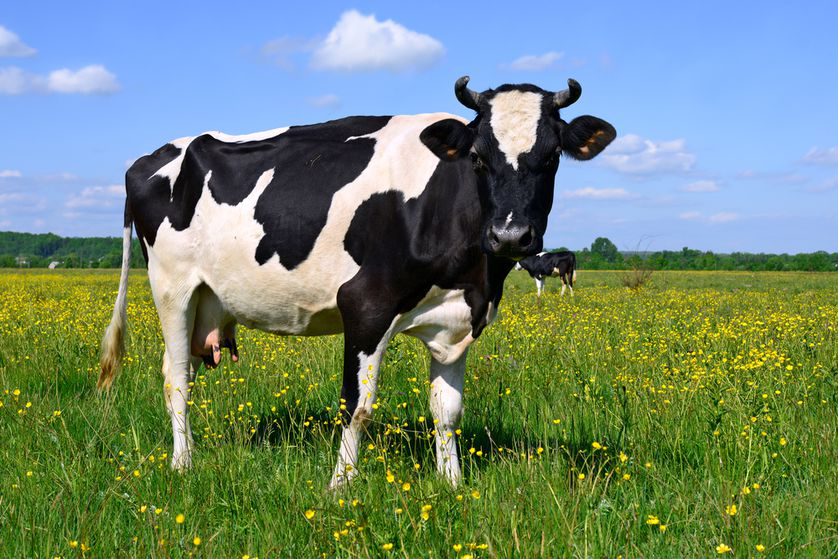

I see a man is milking a horse on a field


In [0]:
def caption_it(img):
  
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)  
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
    
  x1 = encode_model.predict(img)
  x1 = x1.reshape((1, OUTPUT_DIM))
      
  caption = generate_caption(x1)
  
  return " ".join(caption.split()[1:-1])


img = Image.open("cat-2083492_960_720.jpg")

caption = caption_it(img)
display(img)
print("I see "+caption)

## Resources
* https://www.tensorflow.org/beta/tutorials/text/image_captioning
* https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
* https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb
* https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb

## References
1. [Show and Tell: A Neural Image Caption Generator" by Vinyals et al](https://arxiv.org/pdf/1411.4555.pdf)
2. ["BLEU: a Method for Automatic Evaluation of Machine Translation" by Papineni et al](https://www.aclweb.org/anthology/P02-1040)
3. ["Rethinking the Inception Architecture for Computer Vision" by Szegedy et al](https://arxiv.org/pdf/1512.00567.pdf)
4. ["ImageNet: A Large-Scale Hierarchical Image Database" by Deng et al](http://www.image-net.org/papers/imagenet_cvpr09.pdf)
5. ["Efficient Estimation of Word Representations in Vector Space" by Mikolov et al](https://arxiv.org/pdf/1301.3781.pdf)
6. ["GloVe: Global Vectors for Word Representation" by Pennington et al](https://nlp.stanford.edu/pubs/glove.pdf)
7. ["ADAM: A method for stochastic optimization" by Kingma et al](https://arxiv.org/pdf/1412.6980.pdf)